In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def formatBacktestdata(_ccy:str):
    # Formatting
    _tarCol = ['Open time', 'Open', 'High', 'Low', 'Volume', 'Close']
    _Dir = "C:\\Users\\scchanan\\Cryto\\Data\\"
    _filename = '{}USDT.csv'.format(_ccy)
    _histData = pd.read_csv(_Dir + _filename, dtype={'Open time':str})[_tarCol].dropna()
    _histData['datetime'] = pd.to_datetime(_histData['Open time'], format='%Y-%m-%d %H:%M:%S')
    _histData = _histData.sort_values('datetime').reset_index(drop=True)
    _histData['date'] = _histData.datetime.dt.date
    _histData['time'] = _histData.datetime.dt.time
    _histData['symbol'] = _ccy + '/' + 'USDT'
    _histData = _histData[['datetime', 'date', 'time', 'symbol'] + _tarCol]
    _histData = _histData.drop(columns=['Open time'], axis=1)
    return _histData
    
def getRandomPeriod(_date:list, _numDays:int):
    _minDate = datetime.date(2020, 12, 31)
    _maxDate = datetime.date(2021, 10, 31)
    _startPeriod = random.choice(_date)
    _endPeriod = _startPeriod + datetime.timedelta(days=_numDays)
    if (_startPeriod >= _minDate) and (_endPeriod <= _maxDate) :
        return _startPeriod, _endPeriod
    else:
        return getRandomPeriod(_date, _numDays)

# New Model

In [3]:
def Gen_Y(_close:pd.Series, _numPeriod:int):
    _execCost = 0.0005
    _Fore = pd.DataFrame(_close, columns=['Close'])
    _outY = []
    for i in range(1, _numPeriod+1):
        _Fore['Fwd_{}'.format(i)] = (((_Fore['Close'].shift(-i)/_Fore['Close'])-1))
    _Y = (_Fore.drop(['Close'], axis=1) > _execCost).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    return _Y

In [4]:
def Gen_backtesting_data(_ccy:str):
    # Load data
    _data = formatBacktestdata(_ccy)
    #_startDate, _endDate = getRandomPeriod(_date=_data.date.unique(), _numDays=90)
    _TrainStartDate, _TrainEndDate = datetime.date(2020, 12, 31), datetime.date(2021, 10, 31) 
    _TestStartDate, _TestEndDate = datetime.date(2021, 10, 31), datetime.date(2021, 12, 1) 
    _train = _data[(_data.date >= _TrainStartDate) & (_data.date <= _TrainEndDate)].reset_index(drop=True)
    _test = _data[(_data.date >= _TestStartDate) & (_data.date <= _TestEndDate)].reset_index(drop=True)
    for data in [_train, _test]:
        # Normalization
        # Return Lag
        for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
            data['Return_LAG_{}'.format(_lag)] = (data.Close/data.Close.shift(_lag)-1)
        # Realized Volatility
        for _rv in [15, 30, 60, 180, 360, 720, 1440]:
            ann_factor = 1440 * 365 / _rv
            data['RealizedVol_Window_{}'.format(_rv)] = np.sqrt(np.square(data.Return_LAG_1).rolling(_rv).sum().clip(0,None) \
                *ann_factor)
        # ADTV
        for _adtv in [3, 5, 15, 30, 60, 180, 360, 1440]:
            data['ADTV_{}'.format(_adtv)] = data.Volume.rolling(window=_adtv).mean().shift(1)
        # Y
        _execCost = 0.0005
        data['Actual_Y'] = Gen_Y(_close=_data.Close, _numPeriod=3)
    # Cut First and Last Day
    _train = _train[(_train.date > _TrainStartDate) & (_train.date < _TrainEndDate)].reset_index(drop=True)
    _test = _test[(_test.date > _TestStartDate) & (_test.date < _TestEndDate)].reset_index(drop=True)
    return _train, _test

In [5]:
def Gen_backtesting_signal_cont(_data:pd.DataFrame):
    # Signal
    _signaldf = pd.DataFrame(data=[x for x in _data.date], columns=['date'])
    _signaldf['time'] = _data.time
    # Return Lag
    for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
        _signaldf['Return_LAG_{}'.format(_lag)] = _data['Return_LAG_{}'.format(_lag)]
    # Realized Volatility
    RV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['RealizedVol' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['RealizedVol' in \
                          col for col in _data.columns]]].columns)
    # ADTV
    ADTV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['ADTV' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['ADTV' in \
                          col for col in _data.columns]]].columns)
    _signaldf = pd.concat([_signaldf, RV_scaled, ADTV_scaled], axis=1)
    # Y
    _signaldf['Actual_Y'] = _data['Actual_Y']
    
    return _signaldf

In [6]:
def vifcl(df:pd.DataFrame):
    a = 0
    i = 0
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    t = vif["VIF Factor"].max()
    for each in vif["VIF Factor"]:
        if each == t and each >= 10:
            a = i
        i += 1
    vax = vif["VIF Factor"].loc[a]
    print(vif.loc[a],"\n>10")
    return a,vax

In [7]:
def runVIF(df:pd.DataFrame):
    # Raw train/test for VIF
    _VIF_X = df.drop(['date', 'time', 'Actual_Y'], axis=1)
    _VIF_y = df['Actual_Y']
    # First Fit
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(_VIF_X.values, i) for i in range(_VIF_X.shape[1])]
    vif["features"] = _VIF_X.columns
    vif.round(1)
    # Drop VIF>10
    dropcindex=[]
    while True:
        vmax = 0
        dropt = False
        k,s = vifcl(_VIF_X)
        if s >= 10:
            dropt = True
        if dropt == True:
            print("dropped",_VIF_X.columns[k])
            dropcindex.append(_VIF_X.columns[k])
            _VIF_X = _VIF_X.drop([_VIF_X.columns[k]],axis=1)
            vif = vif.drop([k])
            _VIF_X = _VIF_X.reset_index(drop=True)
            vif = vif.reset_index(drop=True)
        else:
            break
    return dropcindex

# Preprocessing, Feature Selection

In [8]:
_dataDict = {}
_ccyList = ['BTC', 'ETH', 'SOL']
for _ccy in _ccyList:
    _dataDict[_ccy] = {}
    _dataDict[_ccy]['Train'], _dataDict[_ccy]['Test'] = Gen_backtesting_data(_ccy)
    # Normalization
    _dataDict[_ccy]['NormalizedTrain'], _dataDict[_ccy]['NormalizedTest'] = \
        Gen_backtesting_signal_cont(_data=_dataDict[_ccy]['Train']), Gen_backtesting_signal_cont(_data=_dataDict[_ccy]['Test'])
    # VIF
    _dataDict[_ccy]['VIFExcluded'] = runVIF(_dataDict[_ccy]['NormalizedTrain'])
    _dataDict[_ccy]['VIFIncluded'] = _dataDict[_ccy]['NormalizedTrain'].columns \
        [~_dataDict[_ccy]['NormalizedTrain'].columns.isin(_dataDict[_ccy]['VIFExcluded'])]
    _dataDict[_ccy]['NVIFTrain'] = _dataDict[_ccy]['NormalizedTrain'][_dataDict[_ccy]['VIFIncluded']]
    _dataDict[_ccy]['NVIFTest'] = _dataDict[_ccy]['NormalizedTest'][_dataDict[_ccy]['VIFIncluded']]

VIF Factor                 34.192083
features      RealizedVol_Window_360
Name: 12, dtype: object 
>10
dropped RealizedVol_Window_360
VIF Factor    29.01537
features       ADTV_30
Name: 17, dtype: object 
>10
dropped ADTV_30
VIF Factor                23.949459
features      RealizedVol_Window_60
Name: 10, dtype: object 
>10
dropped RealizedVol_Window_60
VIF Factor    20.146763
features       ADTV_180
Name: 17, dtype: object 
>10
dropped ADTV_180
VIF Factor                   17.12632
features      RealizedVol_Window_1440
Name: 12, dtype: object 
>10
dropped RealizedVol_Window_1440
VIF Factor    14.944947
features         ADTV_5
Name: 13, dtype: object 
>10
dropped ADTV_5
VIF Factor                11.656868
features      RealizedVol_Window_30
Name: 9, dtype: object 
>10
dropped RealizedVol_Window_30
VIF Factor        2.055123
features      Return_LAG_1
Name: 0, dtype: object 
>10
VIF Factor    33.633341
features        ADTV_30
Name: 18, dtype: object 
>10
dropped ADTV_30
VIF Factor    31

# LOGI

In [9]:
# Post VIF fit
_tarCcy = 'BTC'
_trainX = _dataDict[_tarCcy]['NVIFTrain'].drop(['date', 'time', 'Actual_Y'], axis=1)
_trainy = _dataDict[_tarCcy]['NVIFTrain']['Actual_Y']
_testX = _dataDict[_tarCcy]['NVIFTest'].drop(['date', 'time', 'Actual_Y'], axis=1)
_testy = _dataDict[_tarCcy]['NVIFTest']['Actual_Y']
# Constant
#_trainX = sm.add_constant(_trainX)
#_testX = sm.add_constant(_testX)
model = sm.Logit(_trainy, _trainX)
logi = model.fit(solver='lbfgs', max_iter=1000, C=1e9)
print('Training Data')
display(logi.summary())
display(confusion_matrix(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print(classification_report(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print('Testing Data')
display(confusion_matrix(_testy, (logi.predict(_testX) >= 0.5).astype(int)))
print(classification_report(_testy, (logi.predict(_testX) >= 0.5).astype(int)))

Optimization terminated successfully.
         Current function value: 0.682586
         Iterations 6
Training Data


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Actual_Y   No. Observations:               435327
Model:                          Logit   Df Residuals:                   435311
Method:                           MLE   Df Model:                           15
Date:                Tue, 07 Dec 2021   Pseudo R-squ.:                 0.01524
Time:                        18:36:19   Log-Likelihood:            -2.9715e+05
converged:                       True   LL-Null:                   -3.0175e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Return_LAG_1              17.2903      3.419      5.057      0.000      10.589      23.991
Return_LAG_2             -17.8460      3.418     -5.221      0.000     -24.545     -11.147
Return_LAG_3               1.8661      3.416      0.546      0.585      -4.829       8.561
Return_LAG_4               3.3445      3.405      0.982      0.326      -3.329      10.018
Return_LAG_5               8.4657      2.903      2.917      0.004       2.777      14.155
Return_LAG_7             -28.2800      1.879    -15.051      0.000     -31.963     -24.597
Return_LAG_14              5.2199      1.111      4.700      0.000       3.043       7.397
Return_LAG_28            -18.5986      0.659    -28.235      0.000     -19.890     -17.308
RealizedVol_Window_15      0.1306      0.008     16.995      0.000       0.116       0.146
RealizedVol_Window_180     0.0625      0.008      7.361      0.000       0.046       0.079
RealizedVol_Window_720     0.0086      0.009      0.985      0.324      -0.008       0.026
ADTV_3                     0.0428      0.006      7.578      0.000       0.032       0.054
ADTV_15                   -0.0255      0.009     -2.887      0.004      -0.043      -0.008
ADTV_60                    0.0330      0.008      4.397      0.000       0.018       0.048
ADTV_360                  -0.0199      0.007     -2.753      0.006      -0.034      -0.006
ADTV_1440                  0.0871      0.007     12.989      0.000       0.074       0.100
==========================================================================================
"""

array([[154467,  63244],
       [125960,  91656]], dtype=int64)

              precision    recall  f1-score   support

           0       0.55      0.71      0.62    217711
           1       0.59      0.42      0.49    217616

    accuracy                           0.57    435327
   macro avg       0.57      0.57      0.56    435327
weighted avg       0.57      0.57      0.56    435327

Testing Data


array([[11110,  7501],
       [15006,  9583]], dtype=int64)

              precision    recall  f1-score   support

           0       0.43      0.60      0.50     18611
           1       0.56      0.39      0.46     24589

    accuracy                           0.48     43200
   macro avg       0.49      0.49      0.48     43200
weighted avg       0.50      0.48      0.48     43200



# XGBoost

Training Data


array([[127534,  90177],
       [ 93505, 124111]], dtype=int64)

              precision    recall  f1-score   support

           0       0.58      0.59      0.58    217711
           1       0.58      0.57      0.57    217616

    accuracy                           0.58    435327
   macro avg       0.58      0.58      0.58    435327
weighted avg       0.58      0.58      0.58    435327



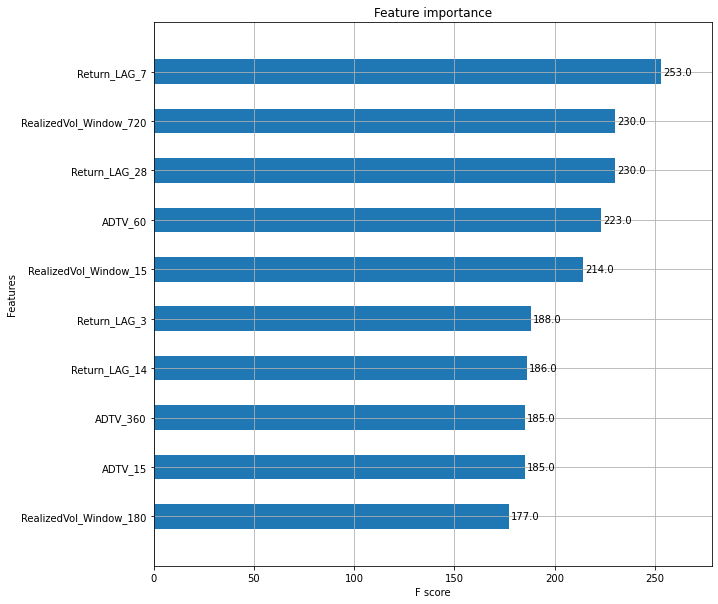

Testing Data


array([[ 9761,  8850],
       [13438, 11151]], dtype=int64)

              precision    recall  f1-score   support

           0       0.42      0.52      0.47     18611
           1       0.56      0.45      0.50     24589

    accuracy                           0.48     43200
   macro avg       0.49      0.49      0.48     43200
weighted avg       0.50      0.48      0.49     43200



In [10]:
# Post VIF fit
_trainX = _dataDict[_tarCcy]['NVIFTrain'].drop(['date', 'time', 'Actual_Y'], axis=1)
_trainy = _dataDict[_tarCcy]['NVIFTrain']['Actual_Y']
_testX = _dataDict[_tarCcy]['NVIFTest'].drop(['date', 'time', 'Actual_Y'], axis=1)
_testy = _dataDict[_tarCcy]['NVIFTest']['Actual_Y']
fix_params = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', \
              'colsample_bytree': 0.35, 'eta': 0.05, 'max_depth': 5, \
              'n_estimators': 100, 'subsample': 0.45, 'use_label_encoder':False}
xg_reg = xgb.XGBClassifier(**fix_params)
xg_reg.fit(_trainX, _trainy)
print('Training Data')
display(confusion_matrix(_trainy, xg_reg.predict(_trainX)))
print(classification_report(_trainy, xg_reg.predict(_trainX)))
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=10, height=0.5, ax=ax,importance_type='weight')
plt.show()
print('Testing Data')
display(confusion_matrix(_testy, xg_reg.predict(_testX)))
print(classification_report(_testy, xg_reg.predict(_testX)))

In [11]:
# PnL
_predicted = pd.Series(xg_reg.predict(_testX), name='Buy_Signal')
_close = _dataDict[_tarCcy]['Test']['Close']
Plotdf = pd.concat([_dataDict[_tarCcy]['Test'].date, _dataDict[_tarCcy]['Test'].time, \
                    _dataDict[_tarCcy]['Test']['Close'], _predicted], axis=1)
Plotdf['BuyPx'] = Plotdf.Close * Plotdf.Buy_Signal

In [12]:
Plotdf

,date,time,Close,Buy_Signal,BuyPx
0,2021-11-01,00:00:00,60491.21,1,60491.21
1,2021-11-01,00:01:00,60509.26,1,60509.26
2,2021-11-01,00:02:00,60530.81,0,0.00
3,2021-11-01,00:03:00,60454.26,1,60454.26
4,2021-11-01,00:04:00,60521.41,1,60521.41
...,...,...,...,...,...
43195,2021-11-30,23:55:00,57627.15,1,57627.15
43196,2021-11-30,23:56:00,57697.33,1,57697.33
43197,2021-11-30,23:57:00,57764.45,1,57764.45
43198,2021-11-30,23:58:00,57626.21,1,57626.21
